# Introduction to PyMC3

Before jumping into cooler and more complex models, we are going to try out PyMC3 with some simple regression models. For most of these examples, non-Bayesian methods would be more than appropriate, but we need to start from some basics, so that we can learn how to use the library correctly.

**Outline of this notebook** : 
 
 - Example 1: Linear Regression
 - Exercise 1: first parameter estimation
 - Example 2: Non-linear Regression
 - Exercise 2: Linear Regression with noise confounders



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

import statsmodels.api as sm
import arviz as az


x = np.linspace(0, 3, 100)
data_t = -1 + 0.5 * x + 0.1 * np.random.randn(1,len(x))
data_outliers = data_t.copy()
data_outliers[:,10] = 0
data_outliers[:,80] = -.5

data_h = -1 + 0.5 * x + x * 0.3 * abs(np.random.randn(1,len(x))) + 0.1 * abs(np.random.randn(1,len(x)))

car_t = np.linspace(0.000001,3, 100)
car_v = 5 * (car_t) + 2* (np.random.randn(1,len(car_t)))**2



## Example 1: Linear Regression

In a linear regression problem, we are trying to estimate the parameters ($\beta, \alpha$) that best describe the data ($x, y$), assuming those come from a linear approximation, and possibly a noise term $\epsilon$

$ y = \beta x + \alpha + \epsilon $

Imagine we have an instrument that measures temperature at different depths (e.g. temperatures from the surface of a material). We know that the temperature varies linearly with depth but that the slope depends on the humidity of the room. Moreover, the measurement error increases in time and the instrument needs to be replaced when the variance is above XXX . 

We would like to estimate the slope $\beta$ and bias $\alpha$ so that we could estimate the humidity, while making sure the instrument is reliable ($\epsilon$)

### Below the measurements:

[-0.5  0.   0.5  1.   1.5  2.   2.5  3.   3.5]


Text(0.5, 1.0, 'Observations')

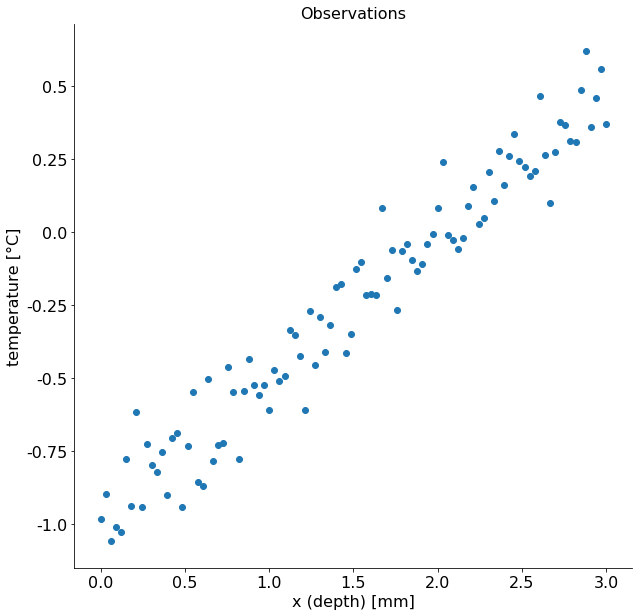

In [2]:
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)

print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1702.
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           9.44e-64
Time:                        17:27:28   Log-Likelihood:                 85.948
No. Observations:                 100   AIC:                            -167.9
Df Residuals:                      98   BIC:                            -162.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9841      0.021    -47.904      0.0

Text(0.5, 1.0, 'Observations')

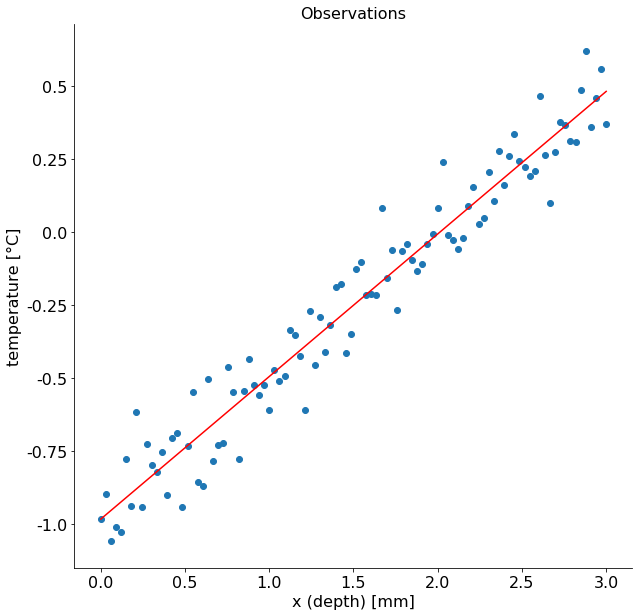

In [3]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_t.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_t)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)


As we mentioned before, for Bayesian inference we need to first make a full model described by appropriate probability distributions.

**Model**
$ y = \beta x + \alpha + \epsilon $

**Likelihood of the data**

Measures are usually normally distributed around the actual temperature values. 

$ y \sim N ( \beta x + \alpha, \epsilon ) $

**Priors of the parameters**:

  - Slope $\beta$, continuous values, $(-\inf, +\inf)$, we know it is usually between 0 and 1.
  - Bias $\alpha$, continuous values, $(-\inf, +\inf)$, the instrument we know has a bias of around $-1$
  - Variance $\epsilon$, continuous values, $(0, +\inf)$
 
$ \beta \sim N ( 0.5 , 1 ) $  
$ \alpha \sim N ( -1 , 1 ) $  
$ \epsilon \sim Gamma ( 1 , 1 ) $  

PyMC3 allows the user to specify the model in a very intuitive way. 



In [4]:
# Data
temperature = data_t
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta, alpha, epsilon]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:17<00:00, 1410.53draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea78fadf60>,
      dtype=object)

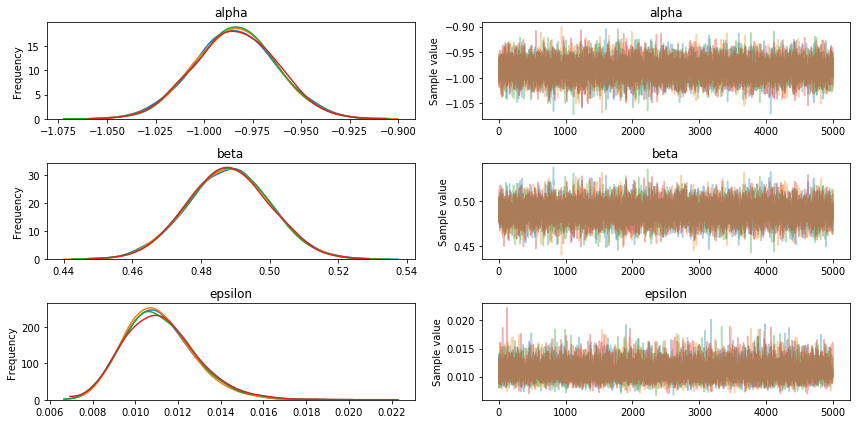

In [5]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

In [6]:
# Descriptive statistic of the posteriors

pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.983978,0.020956,0.000223,-1.024037,-0.942362,9228.927788,0.999976
beta,0.488130,0.011975,0.000126,0.464688,0.511511,9070.445795,0.999948
epsilon,0.011156,0.001648,0.000016,0.008067,0.014356,12234.615074,1.000314


Some further detail on PyMC inference:
 - What is the burn-in?
 - what changes with a different prior?


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [epsilon]
Sampling 2 chains: 100%|██████████| 20002/20002 [00:04<00:00, 4001.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


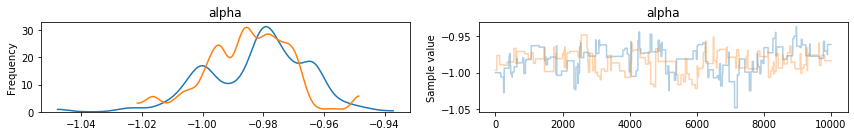

In [7]:
# What is the burnin? 

### We use now a metropolis sampler, that makes more clear what the burnin period is 
SAMPLES = 10000
with model:
    trace = pm.sample(SAMPLES, step=pm.Metropolis(), chains=2, tune = 1)

# Built-in functions for data visualisation
pm.traceplot(trace, varnames=['alpha'])

a1 = trace['alpha']

In [8]:
# What happens if the prior is less informative?
with pm.Model() as model:   
    # Priors
    epsilon = pm.Gamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', 0, 1)  
    beta = pm.Normal('beta', .5, 1)  
    # Likelihood
    obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [epsilon]
Sampling 2 chains: 100%|██████████| 20002/20002 [00:05<00:00, 3954.95draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


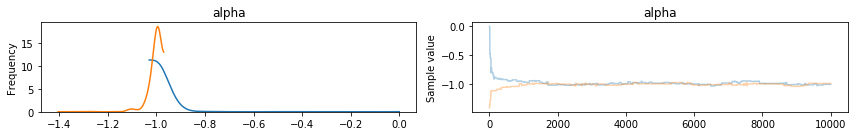

In [9]:
### We use now a metropolis sampler, that makes more clear what the burnin period is 
SAMPLES = 10000
with model:
    trace = pm.sample(SAMPLES, step=pm.Metropolis(),init=False, chains=2, tune = 1)

# Built-in functions for data visualisation
pm.traceplot(trace, varnames=['alpha'])

a2 = trace['alpha']



Text(0.5, 1.0, 'First 1000 samples , alpha = N(0,1)')

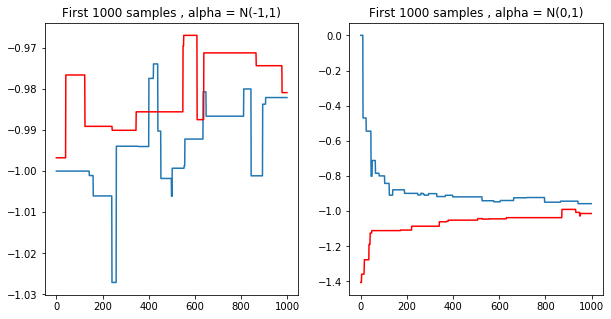

In [10]:
# Comparison of the two traces, remember we used 2 chains
f,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(a1[:1000])
ax[0].plot(a1[SAMPLES:SAMPLES+1000], 'r')
ax[0].set_title('First 1000 samples , alpha = N(-1,1)')
ax[1].plot(a2[:1000])
ax[1].plot(a2[SAMPLES:SAMPLES+1000], 'r')
ax[1].set_title('First 1000 samples , alpha = N(0,1)')


## Exercise 1 

Try to estimate the parameters in the following  scenarios ( they might ring a bell )

a) Estimate the actual temperature of the room, having multiple recordings from different termometers

Text(0.5, 1.0, 'Histogram of the recordings')

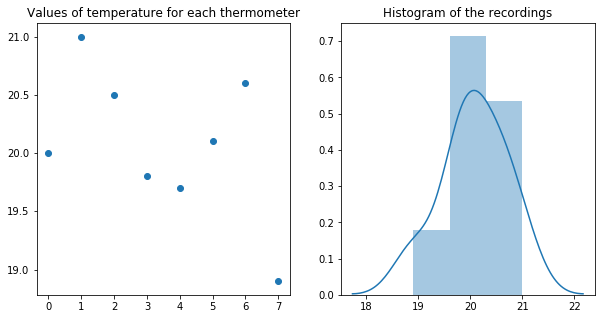

In [11]:
# Solve Exercise 1a here
temperature = [20 , 21, 20.5, 19.8, 19.7, 20.1, 20.6, 18.9, ]

# Plot the data 

f,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].scatter(np.arange(0,8), temperature)
ax[0].set_title('Values of temperature for each thermometer')
sns.distplot(np.array(temperature), ax=ax[1])
ax[1].set_title('Histogram of the recordings')




In [12]:
# Build the model, remember the definition in PyMC3
# with pm.Model() as model_name: ...

with pm.Model() as model_temp:
    m=pm.Normal('m',22,sd=5)
    s = pm.Gamma( 's',1,1)
    
    obs = pm.Normal('obs', mu=m, sd = s, observed = temperature)
    # Evaluate the posterior
    trace = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, m]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2155.08draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea727834a8>],
      dtype=object)

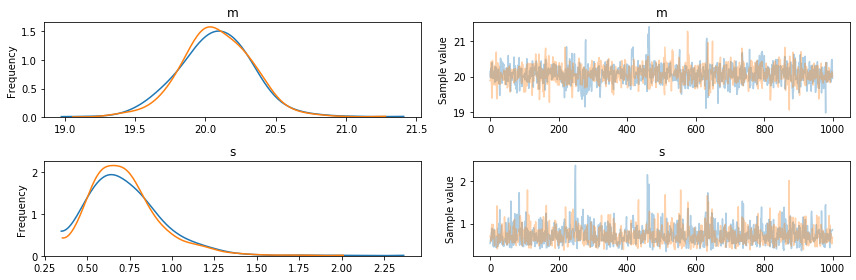

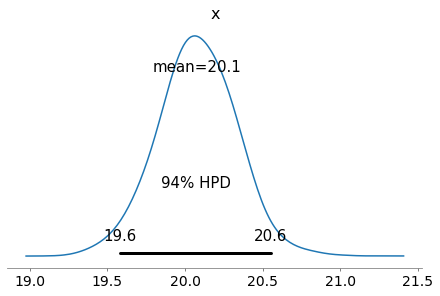

In [13]:
# What can we say on the posterior? Show the summary statistics and some plot
pm.traceplot(trace)

# Posterior of the average temperature
az.plot_posterior(trace['m'])

b) What is the number of points Mark is expected to make during the next tournament 3PC ? During the last trainings he scored 18/25, 22/25, 17/25, 21/25.

In [14]:
# Solve Exercise 1b here

scores = [18,22,17,21]
N = 25

with pm.Model() as model:
    p = pm.Beta('p',5,5) # This is just a generic prior I have chosen, 
                         # try other priors and see how the results are affected by them
    prediction = pm.Deterministic('prediction', N * p)
    obs = pm.Binomial('obs', p = p, n = N, observed = scores)
    trace = pm.sample(2000,tune=2000, chains = 4) # Default are 2, you can play both with the number of chains 
                                                  # and the number of parallel processes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:05<00:00, 2815.91draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea72cc0828>],
      dtype=object)

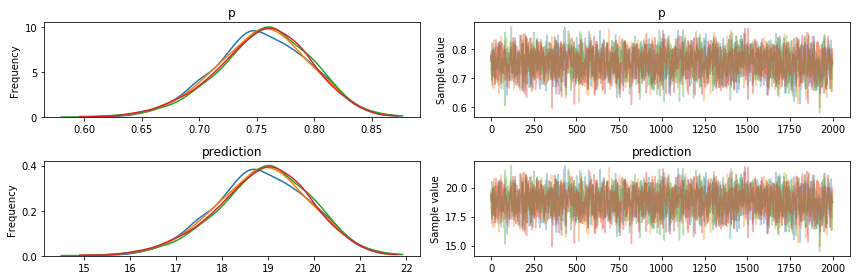

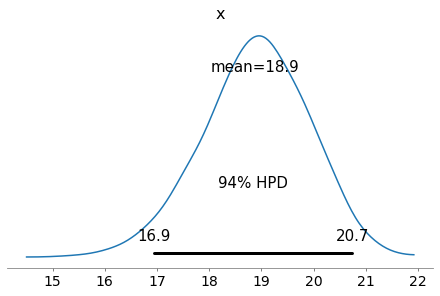

In [15]:
pm.traceplot(trace)
az.plot_posterior(trace['prediction'])



c) How many absent students should we expect during the next week, given that during the last month, out of 25, 
we recorded 24,23,24,24,24,24,25,25,25,20,19,20,22,21,24,25,25,24,25,24,22,23,20,10,25,24,23,25,20,21 students in the classroom.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[ 1  2  1  1  1  1  0  0  0  5  6  5  3  4  1  0  0  1  0  1  3  2  5 15
  0  1  2  0  5  4]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [l]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2990.68draws/s]
The acceptance probability does not match the target. It is 0.8888701835551798, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea7283e550>,
      dtype=object)

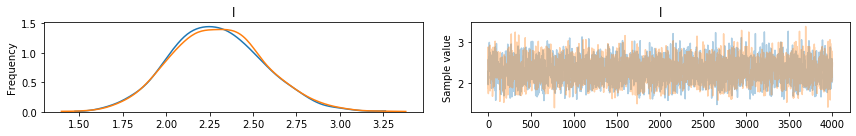

In [16]:
# Solve Exercise 1c here

absent = 25- np.array([24,23,24,24,24,24,25,25,25,20,19,20,22,21,24,25,25,24,25,24,22,23,20,10,25,24,23,25,20,21])
print(absent)

with pm.Model() as model:
    l = pm.Gamma('l',1,1)
    obs = pm.Poisson('obs', l, observed = absent)
    
    trace = pm.sample(4000, tune = 1000)

pm.traceplot(trace)



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea7297ea90>],
      dtype=object)

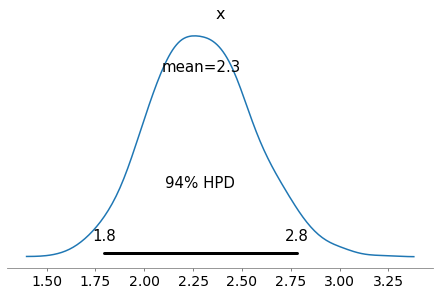

In [17]:
# For a poisson distrbution, the parameter lambda (l in our case) is exactly the expected value

az.plot_posterior(trace['l'])

## Example 3: Non-linear Regression

Adapted from https://docs.pymc.io/notebooks/GLM-poisson-regression.html

As explained before, regression with PyMC can be applied to multiple types of data, as long as the model is coherent with the data. We try now to apply it to some temporal data, using a GLM.

We want now to regress the sneezes of an individual under antihistamine medication.

- The subject sneezes N times per day, recorded as nsneeze (int)
- The subject may or may not take an antihistamine medication during that day, recorded as the negative action nomeds (boolean)
I postulate (probably incorrectly) that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken.
The data is aggregated per day, to yield a total count of sneezes on that day, with a boolean flag for antihistamine usage, with the big assumption that nsneezes have a direct causal relationship.


In [18]:
import pandas as pd
# decide poisson theta values
theta_meds = 1    # no alcohol, took an antihist
theta_nomeds = 4  # no alcohol, no antihist

# create samples
q = 1000
df = pd.DataFrame({
        'nsneeze': np.concatenate((np.random.poisson(theta_meds, q),
                                   np.random.poisson(theta_nomeds, q))),
        'nomeds': np.concatenate((np.repeat(False, q),
                                      np.repeat(True, q))) })

         nomeds
nsneeze  False     0.980
         True      3.902
dtype: float64


/home/viola/miniconda3/envs/smalldata/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


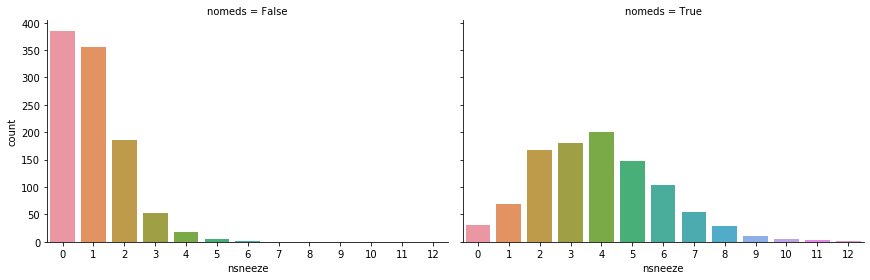

In [19]:
# Average values for nsneezes
print(df.groupby(['nomeds']).mean().unstack())

g = sns.catplot(x='nsneeze',  col='nomeds', data=df,
               kind='count', size=4, aspect=1.5)

The model we use is the following:   
    $ \theta \sim \exp \beta X$  
    $ sneezes \sim Poisson(\theta)$  
Where X is the design matrix, in this case the medication vector.

In [20]:
with pm.Model() as model:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_nomeds', mu=0, sd=10)

    # define linear model and exp link function
    theta = (b0 +
            b1 * df['nomeds'])

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=np.exp(theta), observed=df['nsneeze'].values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b1_nomeds, b0_intercept]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:23<00:00, 1020.13draws/s]
The acceptance probability does not match the target. It is 0.7052947411357214, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0_intercept,-0.021421,0.031972,0.000436,-0.081738,0.042067,5256.134757,0.999955
b1_nomeds,1.382806,0.035811,0.000473,1.311967,1.451030,5393.660814,0.999956


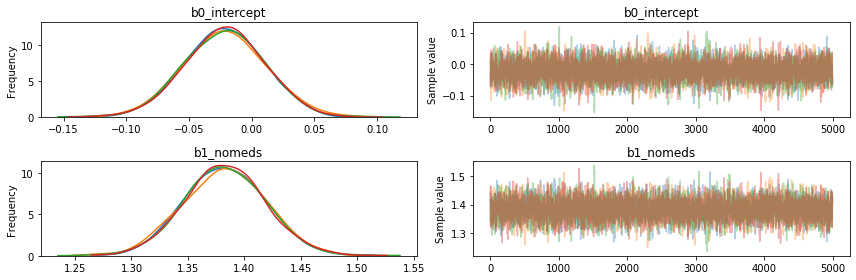

In [21]:
### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

# Descriptive statistic of the posteriors

pm.stats.summary(trace)

In [22]:
np.exp(pm.summary(trace)[['mean','hpd_2.5','hpd_97.5']])


,mean,hpd_2.5,hpd_97.5
b0_intercept,0.978807,0.921513,1.042964
b1_nomeds,3.986071,3.713472,4.267507


# Exercise 2

Try now yourself. This exercises are extension of the linear regression model. I propose a solution, but feel free to explore others, under different assumptions.

We have a recording of speed of a car right after the race started. The engineer explains to us that the measuring device always overestimates the actual value.

What was the acceleration of the car? Is the engineer right? 

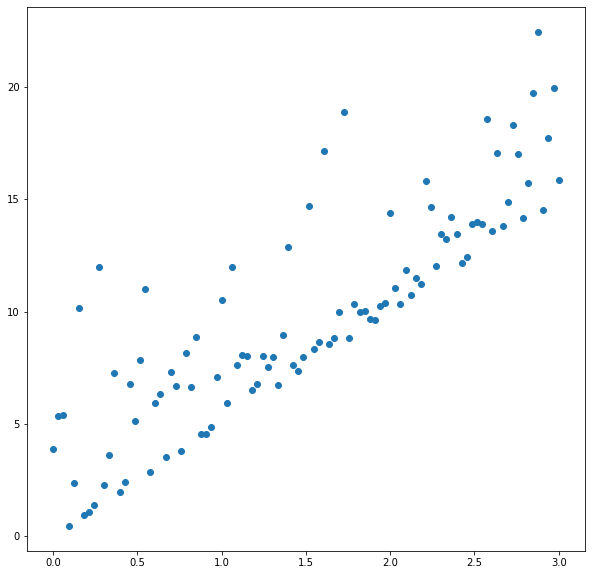

In [23]:
f,ax = plt.subplots(1, figsize = (10,10))
ax.scatter(car_t, car_v)

6.521953867908317


In [26]:
with pm.Model() as model:
    a = pm.Gamma('a',5,1)
    s = pm.Gamma('s',4,1)
    slope= pm.Gamma('slope',10,1)
    obs=pm.SkewNormal('obs',mu = car_t * slope, sd = s, alpha = a, observed = car_v)
    trace = pm.sample(5000,tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, s, a]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:13<00:00, 1430.15draws/s]


            mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff  \
a      11.074025  2.883884  0.028381  5.936309  16.920838  9237.785603   
s       3.538873  0.259843  0.002729  3.053878   4.068876  8901.427374   
slope   4.864064  0.075604  0.000899  4.715337   5.004169  7829.124076   

           Rhat  
a      0.999948  
s      0.999907  
slope  0.999901  
11.074024996841683 3.538872896680406 4.864064322652906
4.5681729086916425


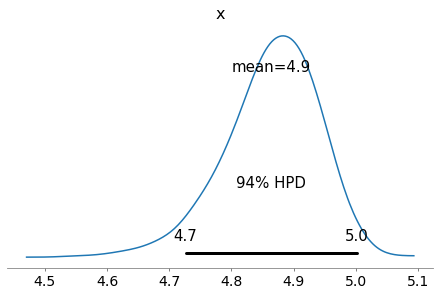

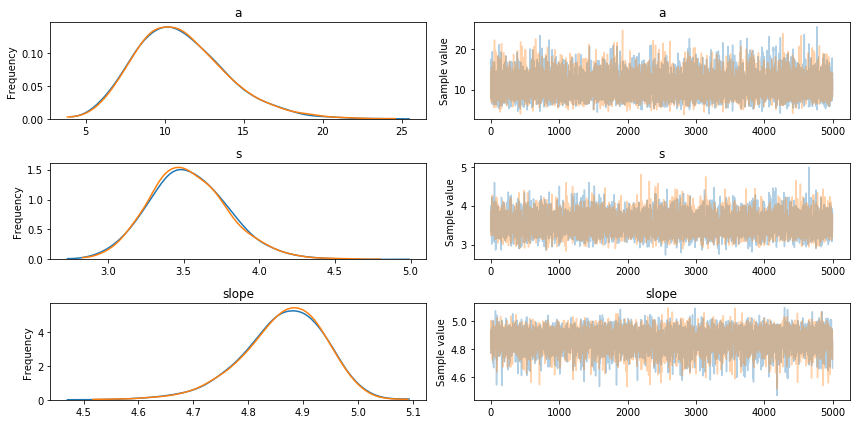

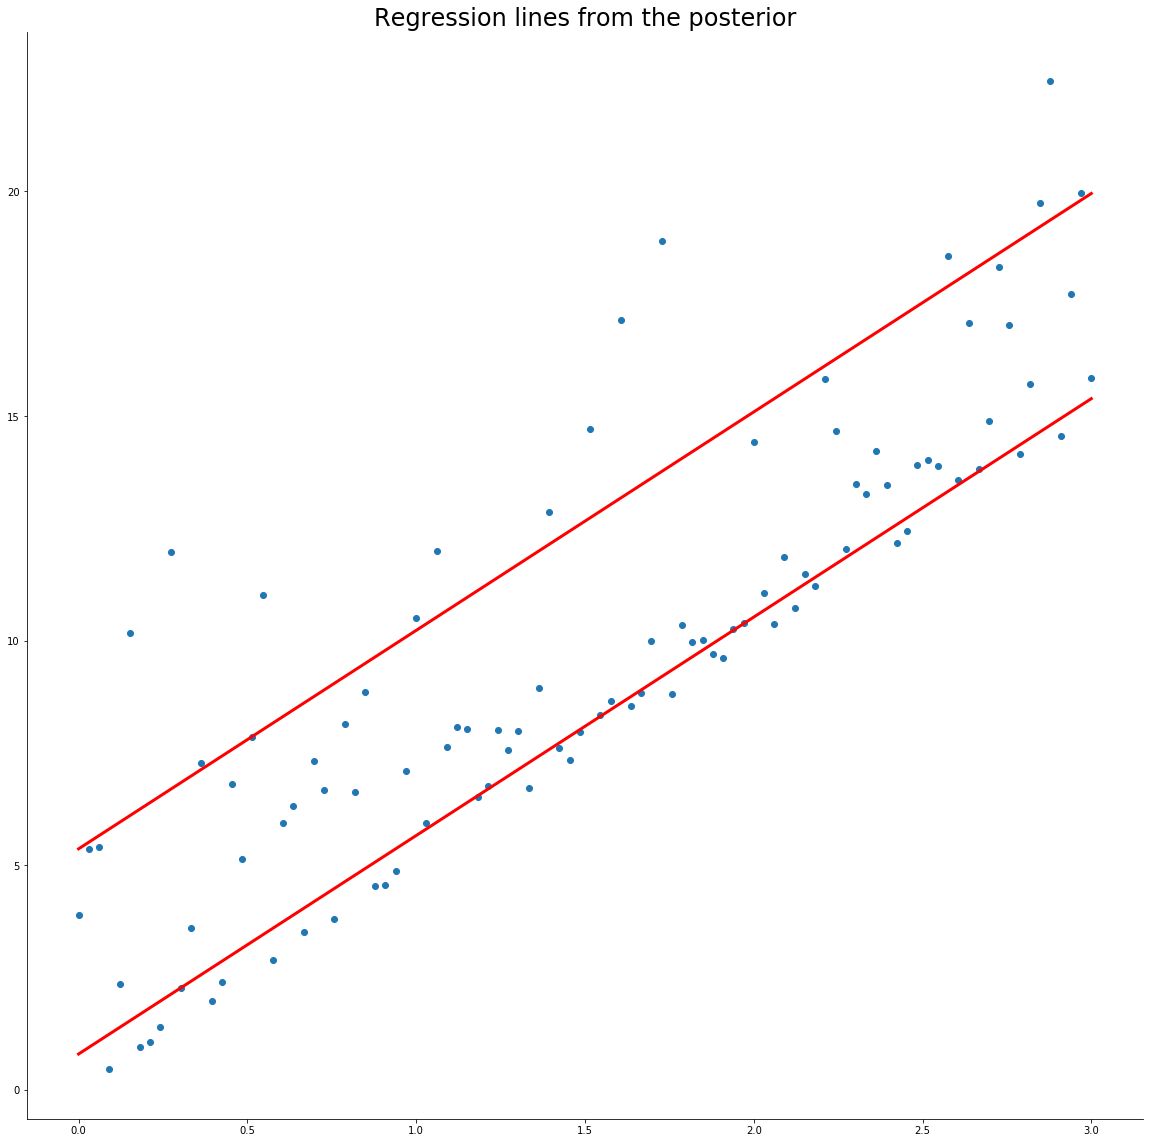

In [27]:
print(pm.summary(trace))

az.plot_posterior(trace['slope'])

a = np.mean(trace['a'])
s = np.mean(trace['s'])
slope = np.mean(trace['slope'])
print(a,s,slope)

pm.traceplot(trace)

# skew normal distribuition has different parameters for mu and sd ( check pymc3 documentation )
m = (car_t*slope) + s*np.sqrt(2*3.14)*(a/(1+a**2) ) 

s2 = (np.median(trace['s']))**2
alpha = np.median(trace['a'])
var = s2*(1. - ((2*alpha**2) / ((alpha**2+1)*3.14) ))
print(var)

f,ax = plt.subplots(1, figsize=(20,20))
ax.set_title('Regression lines from the posterior', fontsize=24)
ax.scatter(car_t, car_v)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(car_t,  m, 'r', lw=3)
ax.plot(car_t,m + var, 'r', lw=3)

# Exercise 3

We have the same recording of exercise 1, but now the error seem to be dependent on the valu

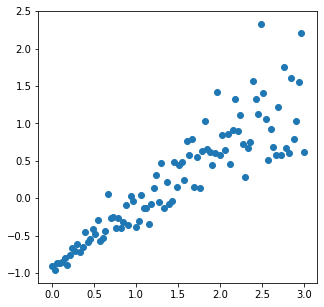

In [28]:
f,ax = plt.subplots(1, figsize = (5,5))
ax.scatter(x, data_h)

In [29]:
with pm.Model() as model_h:
    f = pm.Gamma('f',1,10)
    t = pm.Gamma('t',1,1)
    a = pm.Normal('a',0,5)
    b = pm.Normal('b',1,5)
    obs = pm.Normal('obs', mu = a + b*x, sd = f+t*x, observed = data_h)
    trace = pm.sample(5000, tune = 5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, t, f]
Sampling 2 chains: 100%|██████████| 20000/20000 [00:13<00:00, 1436.99draws/s]


-0.9246591868704818 0.8066286731168377 0.16669487798604524 0.03118835343563102


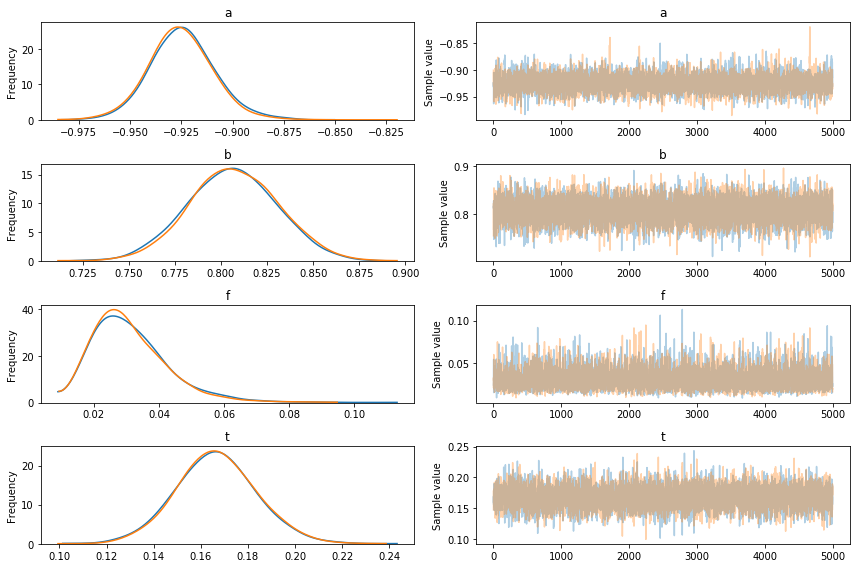

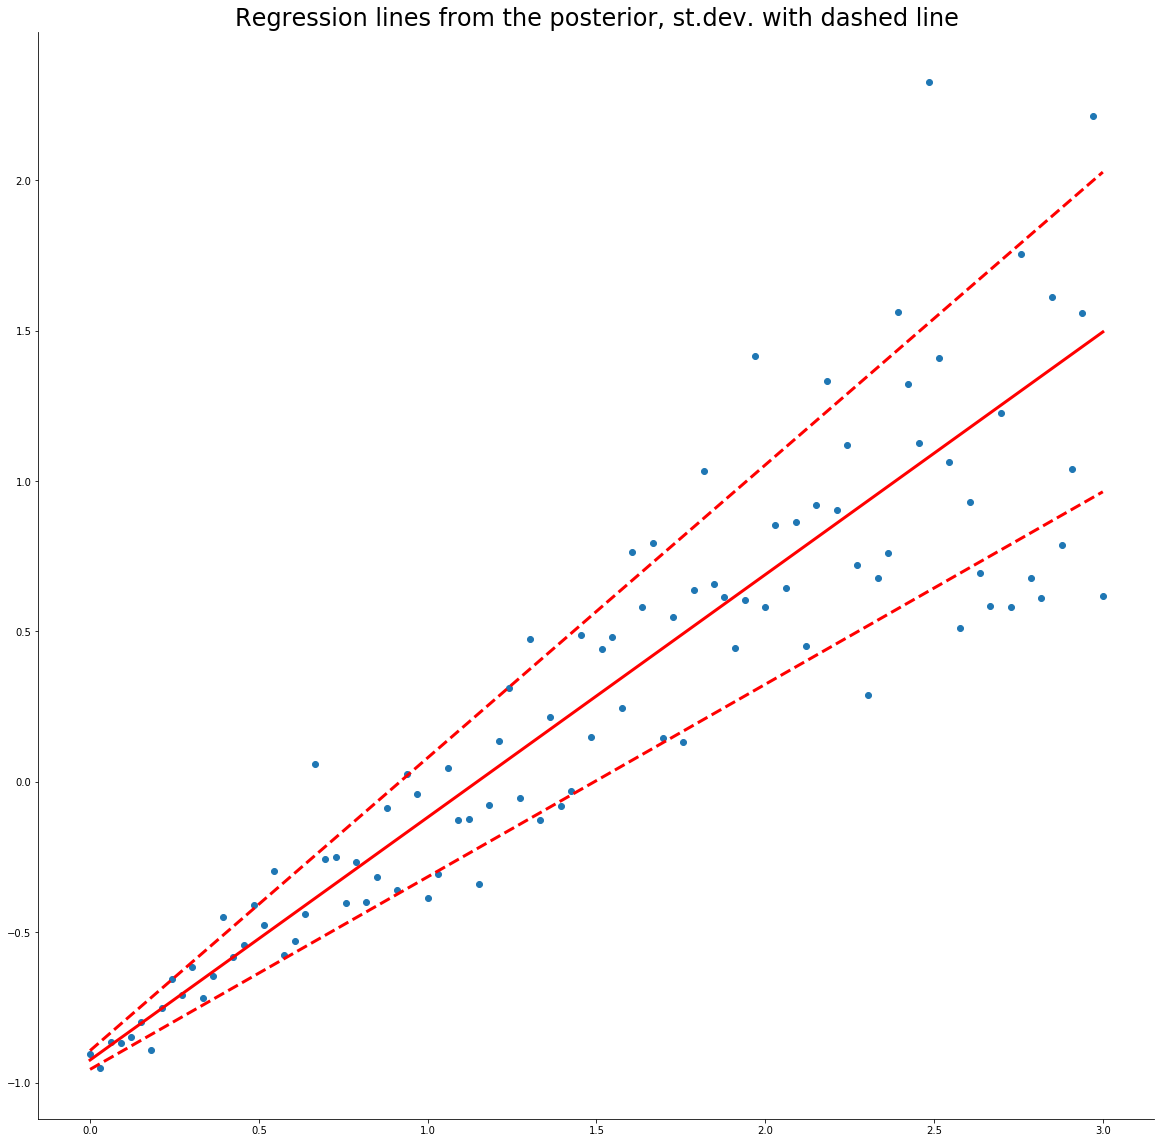

In [30]:
t = np.mean(trace['t'])
f = np.mean(trace['f'])

a = np.mean(trace['a'])
b = np.mean(trace['b'])


pm.traceplot(trace)

fig,ax = plt.subplots(1, figsize=(20,20))
ax.set_title('Regression lines from the posterior, st.dev. with dashed line', fontsize=24)
ax.scatter(x, data_h)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(x, x*b +a, 'r', lw=3)
ax.plot(x,(x*b +a)+(x*t+f), 'r--', lw=3)
ax.plot(x,(x*b +a)-(x*t+f), 'r--', lw=3)

## Linear Regression with Outliers


For full example on outliers refer to: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

In [ ]:
# Results of least square regression 


X=x[:,np.newaxis].copy()
X=sm.add_constant(X)
model = sm.OLS(data_outliers.T, X)
results = model.fit()
print(results.summary())

y=results.params[0]+results.params[1]*x
f,ax= plt.subplots(figsize=(10,10))
ax.scatter(x, data_outliers)
ax.plot(x,y, 'r')
print(ax.get_xticks())
ax.set_xticklabels(ax.get_xticks(), fontsize = 16)
ax.set_yticklabels(ax.get_yticks(), fontsize = 16)
ax.set_xlabel('x (depth) [mm]', fontsize = 16)
ax.set_ylabel('temperature [°C]', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Observations', fontsize= 16)

In [ ]:
# Data
temperature = data_outliers
depth = x

# PyMC3 Model
with pm.Model() as model:   
    # Priors
    epsilon = pm.InverseGamma ('epsilon',1,1)    
    alpha = pm.Normal('alpha', -1, 1)  
    nu = pm.Uniform('nu', lower=1,upper = 100)
    beta = pm.Normal('beta', .5, 1)  
    #beta =  pm.StudentT('beta',nu=.5, mu=.5)
    # Likelihood
    #obs = pm.Normal("obs", mu = alpha + depth * beta, sd = np.sqrt(epsilon), observed = temperature )
    obs = pm.StudentT("obs",nu=nu, mu = alpha + depth * beta, sd = np.sqrt(epsilon),observed = temperature )

    ### Inference, by default it is a NUTS ( non-u-turn sampler) with initialisation
SAMPLES = 5000
BURNIN = 1000
with model:
    trace = pm.sample(SAMPLES, tune=BURNIN, chains=4)

# PyMC3 returns the trace of the sampler ( different backends available.)
# Built-in functions for data visualisation
pm.traceplot(trace)

# Descriptive statistic of the posteriors

pm.stats.summary(trace)